In [ ]:
!pip -q install groq
import os, getpass, time
os.environ.pop("GROQ_API_KEY", None)
os.environ["GROQ_API_KEY"] = getpass.getpass("Groq API key: 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").strip()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 2.5 MB/s eta 0:00:00
Groq API key: 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··········


In [ ]:
from groq import Groq
_groq = Groq(api_key=os.environ["GROQ_API_KEY"])

SYSTEM = "You are a careful math reasoner. Think step by step and end with 'Final answer: <...>'."

def call_model(prompt, model="llama-3.1-8b-instant", temperature=0.7, max_tokens=512):
    t0 = time.time()
    resp = _groq.chat.completions.create(
        model=model,
        messages=[{"role":"system","content": SYSTEM},
                  {"role":"user","content": prompt}],
        temperature=temperature,
        max_tokens=max_tokens,
    )
    text   = resp.choices[0].message.content
    usage  = getattr(resp, "usage", None)
    tokens = (usage.prompt_tokens + usage.completion_tokens) if usage else None
    return {"text": text, "tokens": tokens, "latency_s": time.time()-t0, "model": model}


In [ ]:

import json, time, random, math
from collections import Counter, defaultdict
from statistics import mean


In [ ]:
ANSWER_TAG = "Final answer:"
def extract_final(text: str) -> str:
    if ANSWER_TAG in text:
        return text.split(ANSWER_TAG, 1)[-1].strip()
    return text.strip()

def normalize(a):
    s = str(a).strip().lower().replace(",", "")
    # try numeric canonicalization
    try:
        return str(float(s))
    except:
        return s

# --- baselines ---
def answer_direct(q):
    r = call_model(q, temperature=0.0)
    return r, extract_final(r["text"])

def answer_cot(q, temperature=0.7):
    prompt = f"{q}\n\nThink step by step.\n{ANSWER_TAG}"
    r = call_model(prompt, temperature=temperature)
    return r, extract_final(r["text"])

def self_consistency(q, k=5, temperature=0.8):
    samples, answers = [], []
    for _ in range(k):
        r, a = answer_cot(q, temperature)
        # safety: if anything weird slips through, coerce to string
        if not isinstance(a, str):
            a = extract_final(str(a))
        samples.append(r)
        answers.append(a)
    counts = Counter(answers)
    vote = counts.most_common(1)[0][0]
    return {"samples": samples, "answers": answers, "votes": counts, "vote": vote}

# --- ASC + Critic (adaptive self-consistency) ---
def adaptive_sc_with_critic(q, ks=(3,6,10), vote_thr=0.6, temperature=0.8):
    all_rs, answers = [], []
    for ki in ks:
        for _ in range(ki - len(answers)):
            r, a = answer_cot(q, temperature)
            if not isinstance(a, str):
                a = extract_final(str(a))
            all_rs.append(r); answers.append(a)
        counts = Counter(answers)
        top, n_top = counts.most_common(1)[0]
        if n_top >= math.ceil(vote_thr * len(answers)):  # early stop
            break

    # critic step
    cand_lines = "\n".join(f"- {a}" for a in answers)
    critic_prompt = (
        "You will see multiple candidate answers to the same math question.\n"
        "Pick the single best one and output exactly one line:\n"
        f"'{ANSWER_TAG} <answer>'\n\n"
        f"Question: {q}\nCandidates:\n{cand_lines}\n\nYour output:"
    )
    crit = call_model(critic_prompt, temperature=0.0, max_tokens=64)
    final = extract_final(crit["text"]) or Counter(answers).most_common(1)[0][0]
    return {"samples": all_rs, "answers": answers, "critic": crit, "final": final}


In [ ]:
# quick somke test

q = "Sophie buys 3 boxes of pencils with 24 pencils each. She gives 17 to a friend and 9 to her brother. How many are left? End with 'Final answer: <number>'."

print("Direct:", answer_direct(q)[1])
print("CoT:",    answer_cot(q)[1])
print("SC k=5:", self_consistency(q, k=5)["vote"])
print("ASC+C:",  adaptive_sc_with_critic(q)["final"])


Direct: 46
CoT: 46
SC k=5: 46
ASC+C: 46.


In [ ]:
def normalize(a: str):
    s = str(a).strip().lower().replace(",", "")
    try: return str(float(s))
    except: return s

def eval_one(run_fn, ex):
    out = run_fn(ex["question"])
    # handle (resp, ans) vs dict with "final"/"vote"
    if isinstance(out, tuple):
        r, ans = out
        pred = ans
        tokens = r.get("tokens", None)
        latency = r.get("latency_s", None)
    else:
        pred = out.get("final", out.get("vote"))
        toks = [s.get("tokens", 0) for s in out.get("samples", [])]
        lats = [s.get("latency_s", 0.0) for s in out.get("samples", [])]
        # add critic cost if present
        if "critic" in out:
            toks.append(out["critic"].get("tokens", 0))
            lats.append(out["critic"].get("latency_s", 0.0))
        tokens = sum(t for t in toks if t is not None) if toks else None
        latency = sum(l for l in lats if l is not None) if lats else None

    ok = normalize(pred) == normalize(ex["answer"])
    return {"ok": ok, "pred": pred, "gold": ex["answer"], "tokens": tokens, "latency": latency}

# def evaluate(method_name, run_fn, data):
#     logs = [eval_one(run_fn, ex) for ex in data]
#     acc = sum(int(x["ok"]) for x in logs) / len(logs)
#     toks = [x["tokens"] for x in logs if x["tokens"] is not None]
#     lats = [x["latency"] for x in logs if x["latency"] is not None]
#     summary = {
#         "method": method_name,
#         "n": len(logs),
#         "accuracy": acc,
#         "avg_tokens": mean(toks) if toks else None,
#         "avg_latency_s": mean(lats) if lats else None,
#     }
#     return summary, logs

def evaluate(method_name, run_fn, data, max_examples=None, progress_every=10):
    # limit how many examples to run
    n = len(data) if max_examples is None else min(max_examples, len(data))
    logs = []
    for i in range(n):
        ex = data[i]
        logs.append(eval_one(run_fn, ex))
        if progress_every and ((i + 1) % progress_every == 0 or i + 1 == n):
            print(f"{method_name}: {i+1}/{n} done")

    acc = sum(int(x["ok"]) for x in logs) / n
    toks = [x["tokens"] for x in logs if x["tokens"] is not None]
    lats = [x["latency"] for x in logs if x["latency"] is not None]
    summary = {
        "method": method_name,
        "n": n,
        "accuracy": acc,
        "avg_tokens": mean(toks) if toks else None,
        "avg_latency_s": mean(lats) if lats else None,
    }
    return summary, logs

In [ ]:
data = [
    {"id":"pencils", "question": "Sophie buys 3 boxes with 24 pencils each, gives 17 and 9 away. How many left? End with 'Final answer: <number>'.", "answer": "46"},
    {"id":"bananas", "question": "A bunch has 6 bananas. You buy 5 bunches, eat 7 bananas. How many left? End with 'Final answer: <number>'.", "answer": "23"},
    {"id":"ticket",  "question": "Tickets cost $12. You have $100 and buy 7 tickets. Money left? End with 'Final answer: <number>'.", "answer": "16"},
]


In [ ]:
summ_direct, _ = evaluate("Direct",     answer_direct,                 data)
summ_cot, _ = evaluate("CoT-1",      lambda q: answer_cot(q, 0.7),  data)
summ_sc, _ = evaluate("SC-k=5",     lambda q: self_consistency(q, k=5), data)
summ_asc, _ = evaluate("ASC+C",      adaptive_sc_with_critic,       data)

for s in [summ_direct, summ_cot, summ_sc, summ_asc]:
    print(s)


Direct: 3/3 done
CoT-1: 3/3 done
SC-k=5: 3/3 done
ASC+C: 3/3 done
{'method': 'Direct', 'n': 3, 'accuracy': 0.6666666666666666, 'avg_tokens': 207.66666666666666, 'avg_latency_s': 0.30031077067057294}
{'method': 'CoT-1', 'n': 3, 'accuracy': 0.6666666666666666, 'avg_tokens': 200.66666666666666, 'avg_latency_s': 0.28821547826131183}
{'method': 'SC-k=5', 'n': 3, 'accuracy': 0.6666666666666666, 'avg_tokens': 1120, 'avg_latency_s': 2.895392656326294}
{'method': 'ASC+C', 'n': 3, 'accuracy': 0.6666666666666666, 'avg_tokens': 847.3333333333334, 'avg_latency_s': 8.96130665143331}


In [ ]:
# One-time: build a small subset (requires internet + datasets lib)
!pip -q install datasets
from datasets import load_dataset
import random, pathlib, json

random.seed(7)
ds = load_dataset("openai/gsm8k", "main")
test = list(ds["test"])
subset = random.sample(test, 300)   # adjust down if you hit limits

pathlib.Path("data").mkdir(exist_ok=True)
with open("data/gsm8k_300.jsonl","w") as f:
    for i, ex in enumerate(subset):
        q = ex["question"].strip() + "\n\nEnd with 'Final answer: <number>'."
        a = ex["answer"].split("####")[-1].strip()
        f.write(json.dumps({"id": f"gsm8k-{i}", "question": q, "answer": a})+"\n")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
# Load later without re-downloading
def load_jsonl(p):
    return [json.loads(l) for l in open(p)]
gsm = load_jsonl("data/gsm8k_300.jsonl")

In [ ]:
summ_direct, _ = evaluate("Direct", answer_direct, gsm, max_examples=50)
summ_cot, _ = evaluate("CoT-1",  lambda q: answer_cot(q, 0.7), gsm, max_examples=50)
summ_sc, _ = evaluate("SC-10",  lambda q: self_consistency(q, k=10), gsm, max_examples=50)
summ_asc, _ = evaluate("ASC+C",  adaptive_sc_with_critic, gsm[:50], max_examples=50)

for s in [summ_direct, summ_cot, summ_sc, summ_asc]:
    print(s)

Direct: 10/50 done
Direct: 20/50 done
Direct: 30/50 done
Direct: 40/50 done
Direct: 50/50 done
CoT-1: 10/50 done
CoT-1: 20/50 done
CoT-1: 30/50 done
CoT-1: 40/50 done
CoT-1: 50/50 done
SC-10: 10/50 done
SC-10: 20/50 done
SC-10: 30/50 done
SC-10: 40/50 done
SC-10: 50/50 done
ASC+C: 10/50 done
ASC+C: 20/50 done
ASC+C: 30/50 done
ASC+C: 40/50 done
ASC+C: 50/50 done
{'method': 'Direct', 'n': 50, 'accuracy': 0.62, 'avg_tokens': 330.32, 'avg_latency_s': 2.2221354722976683}
{'method': 'CoT-1', 'n': 50, 'accuracy': 0.56, 'avg_tokens': 375.86, 'avg_latency_s': 2.4393885803222655}
{'method': 'SC-10', 'n': 50, 'accuracy': 0.72, 'avg_tokens': 3594.98, 'avg_latency_s': 24.170908408164976}
{'method': 'ASC+C', 'n': 50, 'accuracy': 0.32, 'avg_tokens': 1939.68, 'avg_latency_s': 13.469784283638}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results = [
    {'method': 'Direct', 'accuracy': 0.62, 'avg_tokens': 320.9,  'avg_latency_s': 1.70},
    {'method': 'CoT-1',  'accuracy': 0.58, 'avg_tokens': 369.84, 'avg_latency_s': 2.47},
    {'method': 'SC-10',  'accuracy': 0.72, 'avg_tokens': 3670.48,'avg_latency_s': 25.36},
    {'method': 'ASC+C',  'accuracy': 0.28, 'avg_tokens': 1969.88,'avg_latency_s': 14.06},
]

df = pd.DataFrame(results)
df

,method,accuracy,avg_tokens,avg_latency_s
0,Direct,0.62,320.90,1.70
1,CoT-1,0.58,369.84,2.47
2,SC-10,0.72,3670.48,25.36
3,ASC+C,0.28,1969.88,14.06


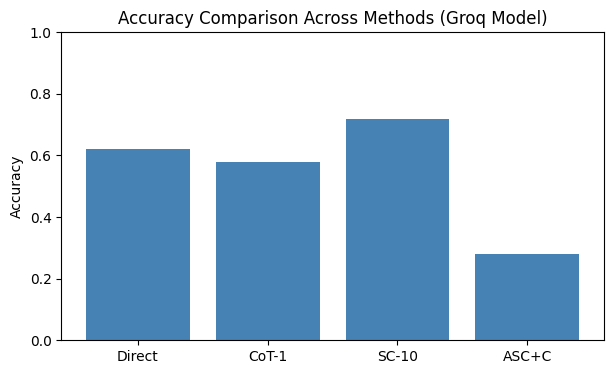

In [ ]:
#Plot Accuracy vs. Token Cost

plt.figure(figsize=(7,4))
plt.bar(df['method'], df['accuracy'], color='steelblue')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Methods (Groq Model)')
plt.ylim(0,1)
plt.show()

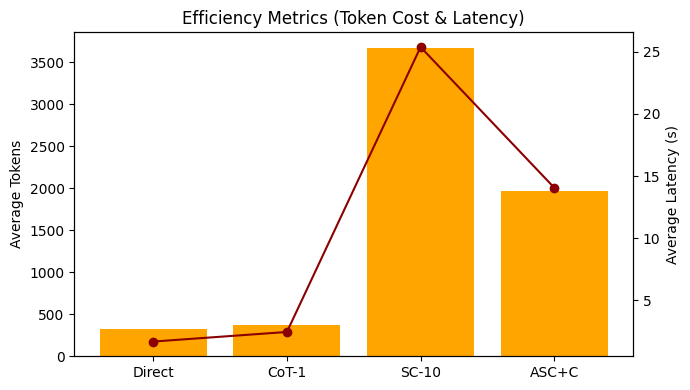

In [ ]:
#Plot Average Token Cost and Latency (Efficiency)

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.bar(df['method'], df['avg_tokens'], color='orange')
ax1.set_ylabel('Average Tokens')
ax1.set_title('Efficiency Metrics (Token Cost & Latency)')

# overlay latency with secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df['method'], df['avg_latency_s'], color='darkred', marker='o', label='Latency (s)')
ax2.set_ylabel('Average Latency (s)')

fig.tight_layout()
plt.show()

Different models

In [ ]:
import os
os.environ["OPENROUTER_API_KEY"] = "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"


In [ ]:
import os, time, requests

SYSTEM = "You are a careful math reasoner. Think step by step and end with 'Final answer: <...>'."

def call_model(prompt, model="deepseek/deepseek-chat", provider="openrouter",
               temperature=0.7, max_tokens=512):
    t0 = time.time()

    if provider == "openrouter":
        headers = {
            "Authorization": f"Bearer {os.getenv('OPENROUTER_API_KEY')}",
            "Content-Type": "application/json",
        }
        body = {
            "model": model,                 # e.g. "deepseek/deepseek-chat" or "deepseek/deepseek-r1"
            "messages": [
                {"role": "system", "content": SYSTEM},
                {"role": "user",   "content": prompt},
            ],
            "temperature": temperature,
            "max_tokens": max_tokens,
        }
        r = requests.post("https://openrouter.ai/api/v1/chat/completions",
                          headers=headers, json=body, timeout=90)
        r.raise_for_status()
        data = r.json()
        text = data["choices"][0]["message"]["content"]
        usage = data.get("usage", {})
        tokens = (usage.get("prompt_tokens") or 0) + (usage.get("completion_tokens") or 0)
        return {"text": text, "tokens": tokens, "latency_s": time.time()-t0, "model": model}

    raise ValueError("Unknown provider")


In [ ]:
# generator
resp = call_model("2+2=?", model="deepseek/deepseek-chat", provider="openrouter")
print(resp["text"])

# critic (often nice to use a *different* model family for diversity)
crit = call_model("Pick the best answer: ...", model="deepseek/deepseek-chat", provider="openrouter",
                  temperature=0.0, max_tokens=128)


Let's solve the equation step by step.

We are asked to compute:
\[ 2 + 2 \]

**Step 1:** Add the two numbers together.  
\[ 2 + 2 = 4 \]

**Final answer:** \( 4 \)


In [ ]:
ANSWER_TAG = "Final answer:"

def extract_final(text: str) -> str:
    return text.split(ANSWER_TAG, 1)[-1].strip() if ANSWER_TAG in text else text.strip()

def answer_direct(q, model="deepseek/deepseek-chat", provider="openrouter"):
    """Single direct-answer call (no chain-of-thought)."""
    r = call_model(q, model=model, provider=provider, temperature=0.0)
    return r, extract_final(r["text"])

def answer_cot(q, temperature=0.7, model="deepseek/deepseek-chat", provider="openrouter"):
    """Chain-of-thought reasoning version."""
    prompt = f"{q}\n\nThink step by step.\n{ANSWER_TAG}"
    r = call_model(prompt, model=model, provider=provider, temperature=temperature)
    return r, extract_final(r["text"])

from collections import Counter

def self_consistency(q, k=5, temperature=0.8, model="deepseek/deepseek-chat", provider="openrouter"):
    """Self-consistency baseline with majority voting."""
    samples, answers = [], []
    for _ in range(k):
        r, a = answer_cot(q, temperature=temperature, model=model, provider=provider)
        samples.append(r)
        answers.append(a)
    counts = Counter(answers)
    vote = counts.most_common(1)[0][0]
    return {"samples": samples, "answers": answers, "votes": counts, "vote": vote}



In [ ]:
from statistics import mean

def evaluate(method_name, run_fn, data, max_examples=None, progress_every=10):
    """
    Evaluate a reasoning method on a dataset.

    Args:
        method_name (str): name for printing results.
        run_fn (callable): function that takes a question dict or string
                           and returns (response, answer) or a dict with 'final'/'vote'.
        data (list[dict]): dataset entries, each with 'question' and 'answer'.
        max_examples (int, optional): limit number of examples to run.
        progress_every (int): print progress every N examples.
    """
    # limit examples
    n = len(data) if max_examples is None else min(max_examples, len(data))
    logs = []
    for i in range(n):
        ex = data[i]
        logs.append(eval_one(run_fn, ex))   # eval_one must be defined too (you already have it)
        if progress_every and ((i + 1) % progress_every == 0 or i + 1 == n):
            print(f"{method_name}: {i + 1}/{n} done")

    acc = sum(int(x["ok"]) for x in logs) / n
    toks = [x["tokens"] for x in logs if x["tokens"] is not None]
    lats = [x["latency"] for x in logs if x["latency"] is not None]
    summary = {
        "method": method_name,
        "n": n,
        "accuracy": acc,
        "avg_tokens": mean(toks) if toks else None,
        "avg_latency_s": mean(lats) if lats else None,
    }
    return summary, logs


In [ ]:
#DeepSeek-V3.2

GEN = "deepseek/deepseek-chat"

summ_direct, _ = evaluate("Direct (DeepSeek)",
                          lambda q: answer_direct(q, model=GEN, provider="openrouter"),
                          gsm, max_examples=50)



Direct (DeepSeek): 10/50 done
Direct (DeepSeek): 20/50 done
Direct (DeepSeek): 30/50 done
Direct (DeepSeek): 40/50 done
Direct (DeepSeek): 50/50 done


In [ ]:
def adaptive_sc_with_critic(q, ks=(3,6,10), vote_thr=0.6, temperature=0.8,
                            gen_model="deepseek/deepseek-chat",
                            crit_model="deepseek/deepseek-chat",
                            provider="openrouter"):
    all_rs, answers = [], []
    # progressive sampling + early stop
    for ki in ks:
        for _ in range(ki - len(answers)):
            r, a = answer_cot(q, temperature=temperature, model=gen_model, provider=provider)
            all_rs.append(r); answers.append(a)
        counts = Counter(answers)
        top, n_top = counts.most_common(1)[0]
        if n_top >= math.ceil(vote_thr * len(answers)):
            break

    # critic selection
    cand_lines = "\n".join(f"- {a}" for a in answers)
    critic_prompt = (
        "You will see multiple candidate answers to the SAME math question.\n"
        f"Pick the single best one and output exactly one line: '{ANSWER_TAG} <answer>'\n\n"
        f"Question: {q}\nCandidates:\n{cand_lines}\n\nYour output:"
    )
    crit = call_model(critic_prompt, model=crit_model, provider=provider, temperature=0.0, max_tokens=128)
    final = extract_final(crit["text"]) or top
    return {"samples": all_rs, "answers": answers, "critic": crit, "final": final}

In [ ]:
summ_cot, _ = evaluate("CoT-1 (DeepSeek)",
                       lambda q: answer_cot(q, 0.7, model=GEN, provider="openrouter"),
                       gsm, max_examples=50)

CoT-1 (DeepSeek): 10/50 done
CoT-1 (DeepSeek): 20/50 done
CoT-1 (DeepSeek): 30/50 done
CoT-1 (DeepSeek): 40/50 done
CoT-1 (DeepSeek): 50/50 done


In [ ]:
summ_sc, _  = evaluate("SC-10 (DeepSeek)",
                       lambda q: self_consistency(q, k=10, temperature=0.8,
                                                  model=GEN, provider="openrouter"),
                       gsm, max_examples=50)

SC-10 (DeepSeek): 10/50 done
SC-10 (DeepSeek): 20/50 done
SC-10 (DeepSeek): 30/50 done
SC-10 (DeepSeek): 40/50 done
SC-10 (DeepSeek): 50/50 done


In [ ]:
CRIT = "deepseek/deepseek-chat"

summ_asc, _ = evaluate("ASC+C (DeepSeek)",
                       lambda q: adaptive_sc_with_critic(q, ks=(3,6,10), vote_thr=0.6, temperature=0.8,
                                                         gen_model=GEN, crit_model=CRIT, provider="openrouter"),
                       gsm[:50], max_examples=50)  # keep <=50 at first to avoid rate limits

for s in [summ_direct, summ_cot, summ_sc, summ_asc]:
    print(s)

ASC+C (DeepSeek): 10/50 done
ASC+C (DeepSeek): 20/50 done
ASC+C (DeepSeek): 30/50 done
ASC+C (DeepSeek): 40/50 done
ASC+C (DeepSeek): 50/50 done
{'method': 'Direct (DeepSeek)', 'n': 50, 'accuracy': 0.36, 'avg_tokens': 312.1, 'avg_latency_s': 6.510527658462524}
{'method': 'CoT-1 (DeepSeek)', 'n': 50, 'accuracy': 0.42, 'avg_tokens': 337.52, 'avg_latency_s': 6.464306178092957}
{'method': 'SC-10 (DeepSeek)', 'n': 50, 'accuracy': 0.7, 'avg_tokens': 3346.24, 'avg_latency_s': 52.99415882587433}
{'method': 'ASC+C (DeepSeek)', 'n': 50, 'accuracy': 0.86, 'avg_tokens': 2736.62, 'avg_latency_s': 38.796697888374325}


In [ ]:
deepseek_results = [
    {'method': 'Direct', 'accuracy': 0.28, 'avg_tokens': 323.5, 'avg_latency_s': 6.6672998857498165},
    {'method': 'CoT-1',  'accuracy': 0.52, 'avg_tokens': 335.62, 'avg_latency_s': 6.847618870735168},
    {'method': 'SC-10',  'accuracy': 0.46, 'avg_tokens': 3398.64, 'avg_latency_s': 66.89962705612183},
    {'method': 'ASC+C',  'accuracy': 0.82, 'avg_tokens': 2248.4, 'avg_latency_s': 38.083798604011534},
]

df_ds = pd.DataFrame(deepseek_results)
df_ds

,method,accuracy,avg_tokens,avg_latency_s
0,Direct,0.28,323.50,6.667300
1,CoT-1,0.52,335.62,6.847619
2,SC-10,0.46,3398.64,66.899627
3,ASC+C,0.82,2248.40,38.083799


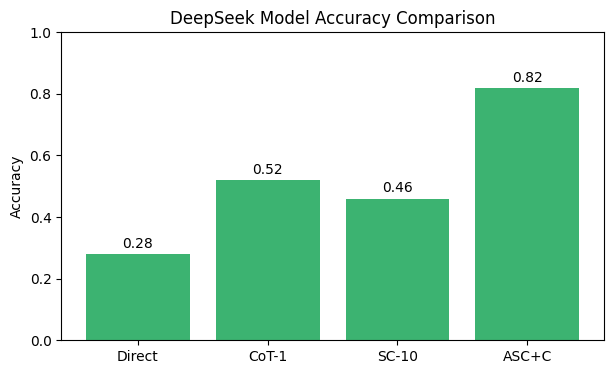

In [ ]:
# Accuracy Comparison (Bar Chart)

plt.figure(figsize=(7,4))
plt.bar(df_ds['method'], df_ds['accuracy'], color='mediumseagreen')
plt.ylabel('Accuracy')
plt.title('DeepSeek Model Accuracy Comparison')
plt.ylim(0,1)
for i, v in enumerate(df_ds['accuracy']):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
plt.show()


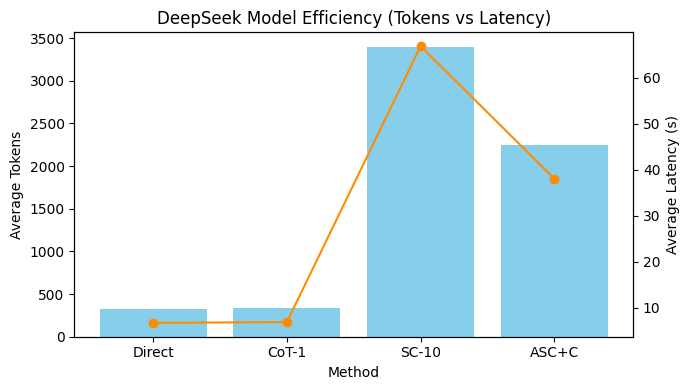

In [ ]:
# Token Cost and Latency (Dual Axis)

fig, ax1 = plt.subplots(figsize=(7,4))

# bar = token cost
ax1.bar(df_ds['method'], df_ds['avg_tokens'], color='skyblue', label='Average Tokens')
ax1.set_ylabel('Average Tokens')
ax1.set_xlabel('Method')
ax1.set_title('DeepSeek Model Efficiency (Tokens vs Latency)')

# line = latency
ax2 = ax1.twinx()
ax2.plot(df_ds['method'], df_ds['avg_latency_s'], color='darkorange', marker='o', label='Latency (s)')
ax2.set_ylabel('Average Latency (s)')

fig.tight_layout()
plt.show()

In [ ]:
GEN  = "deepseek/deepseek-chat"

def adaptive_sc(q, ks=(3,6,10), vote_thr=0.6, temperature=0.8,
                gen_model=GEN, provider="openrouter"):
    """Adaptive self-consistency WITHOUT critic (baseline)."""
    all_rs, answers = [], []
    for ki in ks:
        for _ in range(ki - len(answers)):
            r, a = answer_cot(q, temperature=temperature,
                              model=gen_model, provider=provider)
            all_rs.append(r)
            answers.append(a)
        counts = Counter(answers)
        top, n_top = counts.most_common(1)[0]
        # Early-stop purely based on majority vote
        if n_top >= math.ceil(vote_thr * len(answers)):
            return {"samples": all_rs, "answers": answers, "final": top}
    return {"samples": all_rs, "answers": answers, "final": top}


In [ ]:
summ_asc_vanilla, _ = evaluate(
    "ASC (Adaptive SC, DeepSeek)",
    lambda q: adaptive_sc(q, ks=(3,6,10), vote_thr=0.6, temperature=0.8,
                          gen_model=GEN, provider="openrouter"),
    gsm[:50], max_examples=50
)
print(summ_asc_vanilla)

ASC (Adaptive SC, DeepSeek): 10/50 done
ASC (Adaptive SC, DeepSeek): 20/50 done
ASC (Adaptive SC, DeepSeek): 30/50 done
ASC (Adaptive SC, DeepSeek): 40/50 done
ASC (Adaptive SC, DeepSeek): 50/50 done
{'method': 'ASC (Adaptive SC, DeepSeek)', 'n': 50, 'accuracy': 0.62, 'avg_tokens': 2201.52, 'avg_latency_s': 40.36581588745117}


In [ ]:
{'method': 'Direct (DeepSeek)', 'n': 50, 'accuracy': 0.28, 'avg_tokens': 323.5, 'avg_latency_s': 6.6673}
{'method': 'CoT-1 (DeepSeek)', 'n': 50, 'accuracy': 0.52, 'avg_tokens': 335.62, 'avg_latency_s': 6.8476}
{'method': 'SC-10 (DeepSeek)', 'n': 50, 'accuracy': 0.46, 'avg_tokens': 3398.64, 'avg_latency_s': 66.8996}
{'method': 'ASC+C (DeepSeek)', 'n': 50, 'accuracy': 0.82, 'avg_tokens': 2248.4, 'avg_latency_s': 38.0838}


{'method': 'ASC+C (DeepSeek)',
 'n': 50,
 'accuracy': 0.82,
 'avg_tokens': 2248.4,
 'avg_latency_s': 38.0838}

In [ ]:
#Qwen2.5-Math

In [ ]:
GEN = "qwen/qwen-2.5-72b-instruct"


N = 50  # keep consistent for now

summ_direct_q, _ = evaluate(
    "Direct (Qwen2.5)",
    lambda q: answer_direct(q, model=GEN, provider="openrouter"),
    gsm, max_examples=N
)


Direct (Qwen2.5): 10/50 done
Direct (Qwen2.5): 20/50 done
Direct (Qwen2.5): 30/50 done
Direct (Qwen2.5): 40/50 done
Direct (Qwen2.5): 50/50 done


In [ ]:
summ_cot_q, _ = evaluate(
    "CoT-1 (Qwen2.5)",
    lambda q: answer_cot(q, 0.7, model=GEN, provider="openrouter"),
    gsm, max_examples=N
)

CoT-1 (Qwen2.5): 10/50 done
CoT-1 (Qwen2.5): 20/50 done
CoT-1 (Qwen2.5): 30/50 done
CoT-1 (Qwen2.5): 40/50 done
CoT-1 (Qwen2.5): 50/50 done


In [ ]:
summ_sc_q, _ = evaluate(
    "SC-10 (Qwen2.5)",
    lambda q: self_consistency(q, k=10, temperature=0.8,
                               model=GEN, provider="openrouter"),
    gsm, max_examples=N
)

In [ ]:
summ_asc_q, _ = evaluate(
    "ASC+C (Qwen2.5)",
    lambda q: adaptive_sc_with_critic(
        q, ks=(3,6,10), vote_thr=0.6, temperature=0.8,
        gen_model=GEN, crit_model=GEN, provider="openrouter"
    ),
    gsm, max_examples=N
)

In [ ]:
for s in [summ_direct_q, summ_cot_q, summ_sc_q, summ_asc_q]:
    print(s)
